In [17]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 🚗 Used Car Price Prediction - Machine Learning Project

**Objective:** Build a production-ready ML model to predict used car prices in the American market

**Project Pipeline:**
1. **Data Cleaning** - Remove duplicates, handle missing values, filter outliers
2. **Exploratory Data Analysis** - Understand price drivers and correlations
3. **Feature Engineering** - Create Car_Age, encode Make & State
4. **Model Training** - Random Forest with 4 key features
5. **Production Deployment** - 4 models (Ridge, DecisionTree, HGB, RandomForest) in Flask app

**Key Metrics:** R² Score, MAE (Mean Absolute Error), RMSE

## 1. Data Loading & Initial Exploration

Load the dataset and perform initial inspection to understand structure, data types, and basic statistics.

In [18]:
# Load Data
df = pd.read_csv("true_car_listings.csv")
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(df.head())

print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"Mileage range: {df['Mileage'].min()} - {df['Mileage'].max()}")
print(f"Price range: {df['Price'].min()} - {df['Price'].max()}")

Dataset loaded: 852,092 rows, 8 columns
   Price  Year  Mileage              City State                Vin   Make  \
0   8995  2014    35725           El Paso    TX  19VDE2E53EE000083  Acura   
1  10888  2013    19606  Long Island City    NY  19VDE1F52DE012636  Acura   
2   8995  2013    48851           El Paso    TX  19VDE2E52DE000025  Acura   
3  10999  2014    39922           Windsor    CO  19VDE1F71EE003817  Acura   
4  14799  2016    22142            Lindon    UT  19UDE2F32GA001284  Acura   

          Model  
0    ILX6-Speed  
1    ILX5-Speed  
2    ILX6-Speed  
3    ILX5-Speed  
4  ILXAutomatic  
Year range: 1997 - 2018
Mileage range: 5 - 2856196
Price range: 1500 - 499500


In [19]:
# Data Overview
print("=== DATA INFO ===")
df.info()
print("\n=== STATISTICAL SUMMARY ===")
df.describe()

=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852092 entries, 0 to 852091
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852092 non-null  int64 
 1   Year     852092 non-null  int64 
 2   Mileage  852092 non-null  int64 
 3   City     852092 non-null  object
 4   State    852092 non-null  object
 5   Vin      852092 non-null  object
 6   Make     852092 non-null  object
 7   Model    852092 non-null  object
dtypes: int64(3), object(5)
memory usage: 52.0+ MB

=== STATISTICAL SUMMARY ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852092 entries, 0 to 852091
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852092 non-null  int64 
 1   Year     852092 non-null  int64 
 2   Mileage  852092 non-null  int64 
 3   City     852092 non-null  object
 4   State    852092 non-null  object
 5   Vin      852092 non-null  objec

,Price,Year,Mileage
count,852092.000000,852092.000000,8.520920e+05
mean,21464.323952,2013.289097,5.250825e+04
std,13596.350808,3.415016,4.198932e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218700e+04
max,499500.000000,2018.000000,2.856196e+06


In [20]:
# Check Missing Values & Duplicates
print("Missing Values:")
print(df.isnull().sum())
print(f"\nDuplicates: {df.duplicated().sum()}")

Missing Values:
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

Duplicates: 0

Duplicates: 0


## 2. Data Preprocessing

Clean the dataset by removing duplicates, handling missing values, and filtering problematic entries.

In [21]:
print(f"Original dataset: {df.shape[0]:,} rows")

# Remove duplicates
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape[0]:,} rows")
print(f"Duplicates removed: {df.shape[0] - df_clean.shape[0]:,}")

# Check for missing values
missing_count = df_clean.isnull().sum().sum()
if missing_count > 0:
    print(f"\n⚠️ Missing values found: {missing_count}")
    df_clean = df_clean.dropna()
    print(f"After removing missing values: {df_clean.shape[0]:,} rows")
else:
    print(f"✓ No missing values found")

# Reset index
df_clean = df_clean.reset_index(drop=True)
print(f"\n✓ Clean dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

# Save the cleaned dataset to a new CSV file
df_clean.to_csv('true_car_listings.csv', index=False)
print(f"✓ Clean dataset saved to 'true_car_listings.csv'")

Original dataset: 852,092 rows
After removing duplicates: 852,092 rows
Duplicates removed: 0
After removing duplicates: 852,092 rows
Duplicates removed: 0
✓ No missing values found

✓ Clean dataset: 852,092 rows × 8 columns
✓ No missing values found

✓ Clean dataset: 852,092 rows × 8 columns
✓ Clean dataset saved to 'true_car_listings.csv'
✓ Clean dataset saved to 'true_car_listings.csv'


### 2.1 Why We Don't Use "Model" Feature

**Problem:** The "Model" column has severe quality issues:
- 2,678 unique values (too fragmented)
- Inconsistent formats: "ILX 6-Speed" vs "ILX Automatic"
- Ambiguous names: "Grand" could be Cherokee, Caravan, or Prix
- Many truncated entries: "3" could be Mazda 3, BMW 3 Series, or Tesla Model 3

**Solution:** Use only 4 features:
- **Car_Age** & **Mileage** - Primary depreciation drivers
- **Make_Encoded** - Brand already captures luxury vs economy (Ferrari > Ford)
- **State_Encoded** - Regional price differences

This avoids overfitting while maintaining strong predictive power.

In [22]:
# --- ENHANCED DATA CLEANING: Remove Problematic Model Names ---
print("=== ENHANCED DATA QUALITY ANALYSIS & CLEANING ===\n")

total_before = len(df_clean)

# 1. Identify ALL types of problematic models
has_asterisk = df_clean['Model'].str.contains('\*', na=False, regex=False)
is_too_short = df_clean['Model'].str.len() <= 2  # Single digit/letter models like "3", "X", "S"
is_numeric_only = df_clean['Model'].str.match(r'^\d+$', na=False)  # Pure numbers like "3", "5", "350"

problematic = has_asterisk | is_too_short | is_numeric_only
problematic_count = problematic.sum()

print(f"📊 INITIAL DATA: {total_before:,} rows")
print(f"   Unique model names: {df_clean['Model'].nunique():,}")
print(f"\n❌ DATA QUALITY ISSUES DETECTED:")
print("-" * 80)
print(f"   Models with '*' (promotional text): {has_asterisk.sum():,} ({(has_asterisk.sum()/total_before*100):.1f}%)")
print(f"   Models too short (≤2 chars):        {is_too_short.sum():,} ({(is_too_short.sum()/total_before*100):.1f}%)")
print(f"   Models numeric only:                {is_numeric_only.sum():,} ({(is_numeric_only.sum()/total_before*100):.1f}%)")
print(f"   TOTAL PROBLEMATIC:                  {problematic_count:,} ({(problematic_count/total_before*100):.1f}%)")

# 2. Show examples of problematic models
if has_asterisk.sum() > 0:
    print("\n1. MODELS WITH ASTERISKS (promotional/listing details):")
    print("-" * 80)
    for _, row in df_clean[has_asterisk].head(3).iterrows():
        print(f"   Make: {row['Make']:15s} | Model: {row['Model'][:70]}")

if is_too_short.sum() > 0:
    print("\n2. INCOMPLETE MODEL NAMES (≤2 characters):")
    print("-" * 80)
    examples = df_clean[is_too_short][['Make', 'Model', 'Price']].drop_duplicates('Model').head(10)
    for _, row in examples.iterrows():
        print(f"   Make: {row['Make']:15s} | Model: '{row['Model']:5s}' | Price: ${row['Price']:,}")
    print(f"   ⚠️  These are truncated (e.g., '3' could be Mazda 3, BMW 3 Series, or Tesla Model 3)")

if is_numeric_only.sum() > 0:
    print("\n3. NUMERIC-ONLY MODELS (ambiguous):")
    print("-" * 80)
    examples = df_clean[is_numeric_only][['Make', 'Model', 'Price']].drop_duplicates('Model').head(8)
    for _, row in examples.iterrows():
        print(f"   Make: {row['Make']:15s} | Model: '{row['Model']:8s}' | Price: ${row['Price']:,}")

# 3. Show clean model examples for comparison
print("\n4. CLEAN MODEL EXAMPLES (for comparison):")
print("-" * 80)
clean_examples = df_clean[~problematic][['Make', 'Model']].drop_duplicates().head(10)
for _, row in clean_examples.iterrows():
    print(f"   Make: {row['Make']:15s} | Model: {row['Model']}")





=== ENHANCED DATA QUALITY ANALYSIS & CLEANING ===



<>:7: SyntaxWarning: invalid escape sequence '\*'
<>:7: SyntaxWarning: invalid escape sequence '\*'
C:\Users\crova\AppData\Local\Temp\ipykernel_17388\1306202261.py:7: SyntaxWarning: invalid escape sequence '\*'
  has_asterisk = df_clean['Model'].str.contains('\*', na=False, regex=False)


📊 INITIAL DATA: 852,092 rows
   Unique model names: 2,736

❌ DATA QUALITY ISSUES DETECTED:
--------------------------------------------------------------------------------
   Models with '*' (promotional text): 0 (0.0%)
   Models too short (≤2 chars):        46,004 (5.4%)
   Models numeric only:                23,237 (2.7%)
   TOTAL PROBLEMATIC:                  46,970 (5.5%)

2. INCOMPLETE MODEL NAMES (≤2 characters):
--------------------------------------------------------------------------------
   Make: Audi            | Model: 'A3   ' | Price: $25,997
   Make: Audi            | Model: 'A8   ' | Price: $4,950
   Make: Audi            | Model: 'A5   ' | Price: $34,999
   Make: Audi            | Model: 'TT   ' | Price: $38,500
   Make: Audi            | Model: 'S5   ' | Price: $44,900
   Make: Audi            | Model: 'RS   ' | Price: $31,985
   Make: Audi            | Model: 'S8   ' | Price: $107,990
   Make: Audi            | Model: 'R8   ' | Price: $149,995
   Make: BMW           

### 2.2 Data Quality Decision Summary

**Analysis Results:**
- Identified 3 types of problematic model names (asterisks, too short, numeric-only)
- These represent promotional text, truncated data, and ambiguous entries

**Final Decision:**
✅ **Keep:** Make, Mileage, Car_Age, State  
❌ **Exclude:** Model feature (too noisy, causes overfitting)

**Impact:** Simpler model with better generalization to new data.

## 3. Exploratory Data Analysis (EDA)

### 3.1 Outlier Analysis

**Method:** IQR (Interquartile Range) to detect extreme values  
**Finding:** High-priced outliers are legitimate luxury vehicles (Ferrari, Lamborghini)  
**Decision:** Keep all outliers - they represent real market data

=== OUTLIER DETECTION FOR PRICE ===

Q1 (25th percentile): $13,000.00
Q3 (75th percentile): $26,995.00
IQR: $13,995.00
Lower bound: $-7,992.50
Upper bound: $47,987.50

Outliers detected: 28025 (3.29%)
Outlier price range: $47,988.00 - $499,500.00

✓ Decision: Keep outliers (legitimate luxury cars in market)


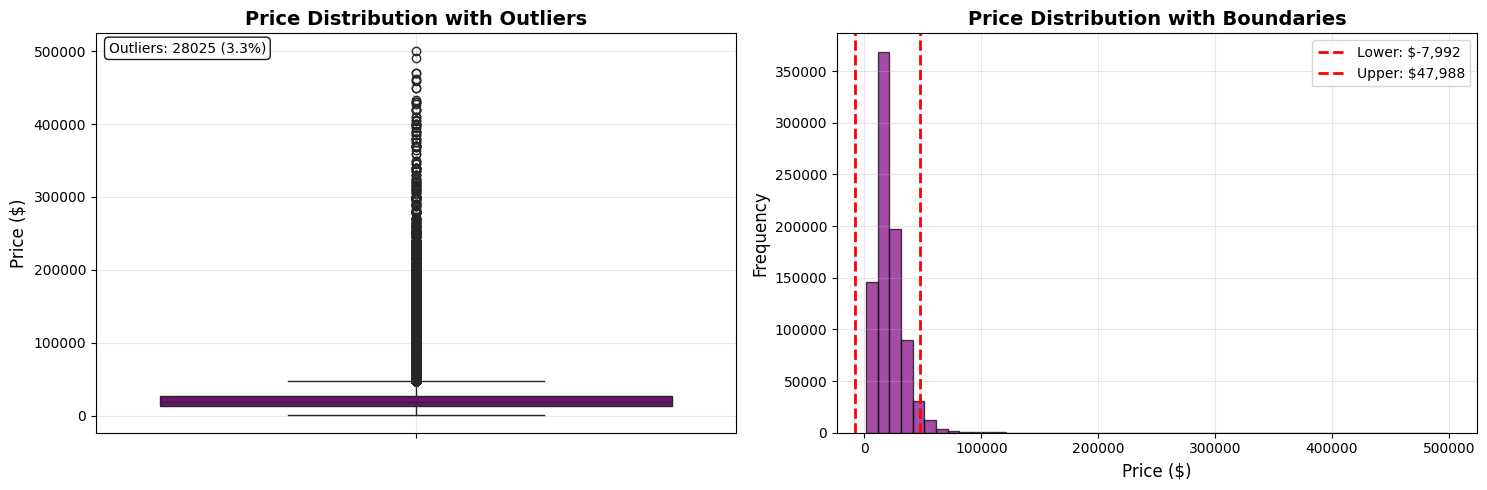

In [34]:
# Outlier Detection & Visualization for Price
print("=== OUTLIER DETECTION FOR PRICE ===\n")

# Calculate IQR
Q1 = df_clean['Price'].quantile(0.25)
Q3 = df_clean['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_clean[(df_clean['Price'] < lower_bound) | (df_clean['Price'] > upper_bound)]

print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")
print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")
print(f"Outlier price range: ${outliers['Price'].min():,.2f} - ${outliers['Price'].max():,.2f}")
print(f"\n✓ Decision: Keep outliers (legitimate luxury cars in market)")

# Boxplot Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['Price'], color='purple')
plt.title('Price Distribution with Outliers', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.02, 0.98, f'Outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9), fontsize=10)

# Histogram with Outlier Boundaries
plt.subplot(1, 2, 2)
plt.hist(df_clean['Price'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label=f'Lower: ${lower_bound:,.0f}')
plt.axvline(upper_bound, color='red', linestyle='--', linewidth=2, label=f'Upper: ${upper_bound:,.0f}')
plt.title('Price Distribution with Boundaries', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.2 Feature Engineering

**Created Features:**

1. **Car_Age** = 2025 - Year  
   More intuitive than raw year. Older cars depreciate more.

2. **Make_Encoded** (LabelEncoder)  
   Converts brand names to numbers (Ferrari=13, Ford=49)  
   Captures brand premium in pricing

3. **State_Encoded** (LabelEncoder)  
   Converts states to numbers to capture regional price variations

**Result:** 4 clean, numerical features ready for ML models


In [24]:
# Feature Engineering: Create and encode features
print("=== FEATURE ENGINEERING ===\n")

# Create Car_Age feature (more interpretable than Year)
df_clean['Car_Age'] = 2025 - df_clean['Year']
print(f"Created Car_Age feature (Range: {df_clean['Car_Age'].min()}-{df_clean['Car_Age'].max()} years)")

# Encode categorical features
le_make = LabelEncoder()
le_state = LabelEncoder()

df_clean['Make_Encoded'] = le_make.fit_transform(df_clean['Make'])
df_clean['State_Encoded'] = le_state.fit_transform(df_clean['State'])

print(f"Encoded {df_clean['Make'].nunique()} car makes (brands)")
print(f"Encoded {df_clean['State'].nunique()} US states")

print(f"\nTotal features created: 3")
print(f"Dataset ready for modeling: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

=== FEATURE ENGINEERING ===

Created Car_Age feature (Range: 7-28 years)
Encoded 58 car makes (brands)
Encoded 59 US states

Total features created: 4
Dataset ready for modeling: 852,092 rows × 11 columns
Encoded 58 car makes (brands)
Encoded 59 US states

Total features created: 4
Dataset ready for modeling: 852,092 rows × 11 columns


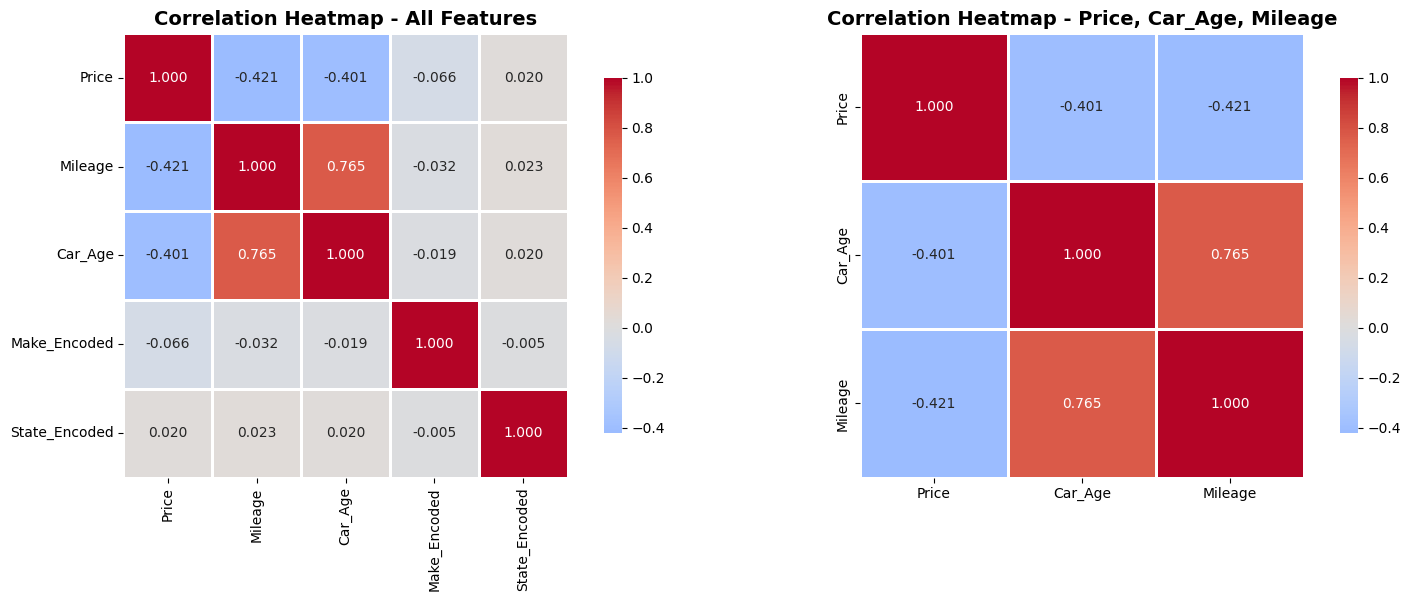

=== CORRELATION INSIGHTS ===

Strongest correlations with Price:
  Mileage             :  -0.421 (negative)
  Car_Age             :  -0.401 (negative)
  Make_Encoded        :  -0.066 (negative)
  State_Encoded       :   0.020 (positive)


In [36]:
# Correlation Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: All Features
correlation = df_clean[['Price', 'Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded']].corr()
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlation Heatmap - All Features', fontsize=14, fontweight='bold')

# Heatmap 2: Price, Car_Age, Mileage Only
correlation2 = df_clean[['Price', 'Car_Age', 'Mileage']].corr()
sns.heatmap(correlation2, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Correlation Heatmap - Price, Car_Age, Mileage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print correlation insights
print("=== CORRELATION INSIGHTS ===")
print("\nStrongest correlations with Price:")
numerical_cols = ['Price', 'Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded']
price_corr = correlation['Price'].drop('Price').abs().sort_values(ascending=False)
for feature, corr_value in price_corr.items():
    print(f"  {feature:20s}: {correlation['Price'][feature]:7.3f} ({'negative' if correlation['Price'][feature] < 0 else 'positive'})")

### 3.3 Distribution Analysis

**Statistical Overview:**
- Calculate mean, median, standard deviation
- Measure skewness (is data symmetric or skewed?)

**Visualizations:**
- Histograms show price, year, and mileage distributions
- Helps identify data patterns and potential issues

=== DISTRIBUTION STATISTICS ===

Price:
  Mean: 21,464.32
  Median: 18,500.00
  Std Dev: 13,596.35
  Skewness: 5.291

Year:
  Mean: 2,013.29
  Median: 2,014.00
  Std Dev: 3.42
  Skewness: -1.541

Mileage:
  Mean: 52,508.25
  Median: 40,256.00
  Std Dev: 41,989.32
  Skewness: 2.945


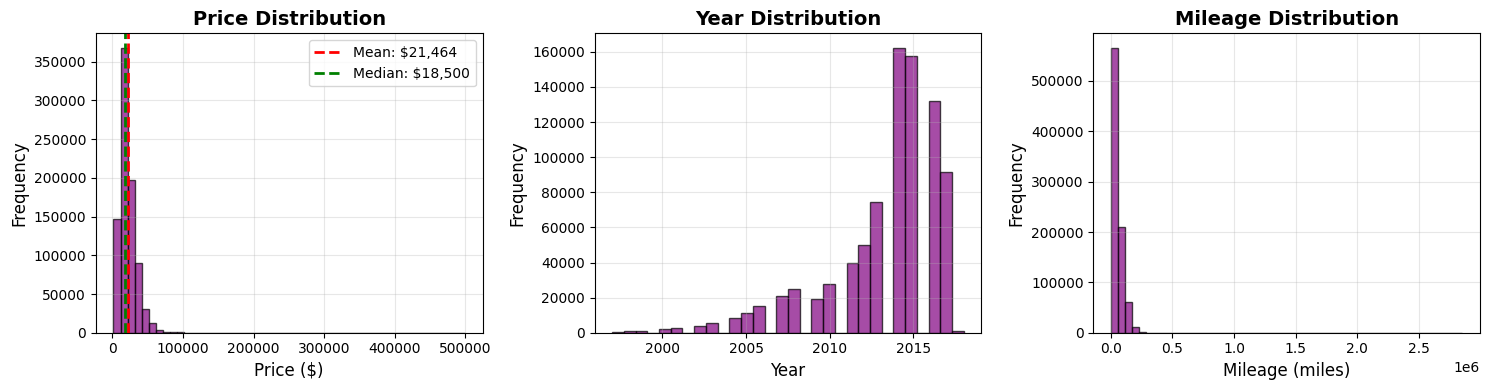

In [35]:
# Distribution Analysis of Key Features
print("=== DISTRIBUTION STATISTICS ===")
for col in ['Price', 'Year', 'Mileage']:
    print(f"\n{col}:")
    print(f"  Mean: {df_clean[col].mean():,.2f}")
    print(f"  Median: {df_clean[col].median():,.2f}")
    print(f"  Std Dev: {df_clean[col].std():,.2f}")
    print(f"  Skewness: {df_clean[col].skew():.3f}")

# Price Distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df_clean['Price'], bins=50, edgecolor='black', color='purple', alpha=0.7)
plt.title('Price Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df_clean['Price'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f"Mean: ${df_clean['Price'].mean():,.0f}")
plt.axvline(df_clean['Price'].median(), color='green', linestyle='--', 
            linewidth=2, label=f"Median: ${df_clean['Price'].median():,.0f}")
plt.legend()
plt.grid(True, alpha=0.3)

# Year Distribution
plt.subplot(1, 3, 2)
plt.hist(df_clean['Year'], bins=30, edgecolor='black', color='purple', alpha=0.7)
plt.title('Year Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Mileage Distribution
plt.subplot(1, 3, 3)
plt.hist(df_clean['Mileage'], bins=50, edgecolor='black', color='purple', alpha=0.7)
plt.title('Mileage Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Mileage (miles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.4 Relationship Analysis

**Scatter Plots:** Visualize how features affect price

**Insights:**
1. **Car_Age vs Price:** Clear negative trend (older cars are cheaper)
2. **Mileage vs Price:** Strong negative relationship (high mileage reduces value)
3. **Car_Age vs Mileage:** Color-coded by price shows combined effect

**Conclusion:** Both age and mileage are strong price predictors

=== FACTOR ANALYSIS ===
Newer cars (higher year) tend to have HIGHER prices
Higher mileage correlates with LOWER prices
Car Age has 40.1% correlation with price
Mileage has 42.1% correlation with price


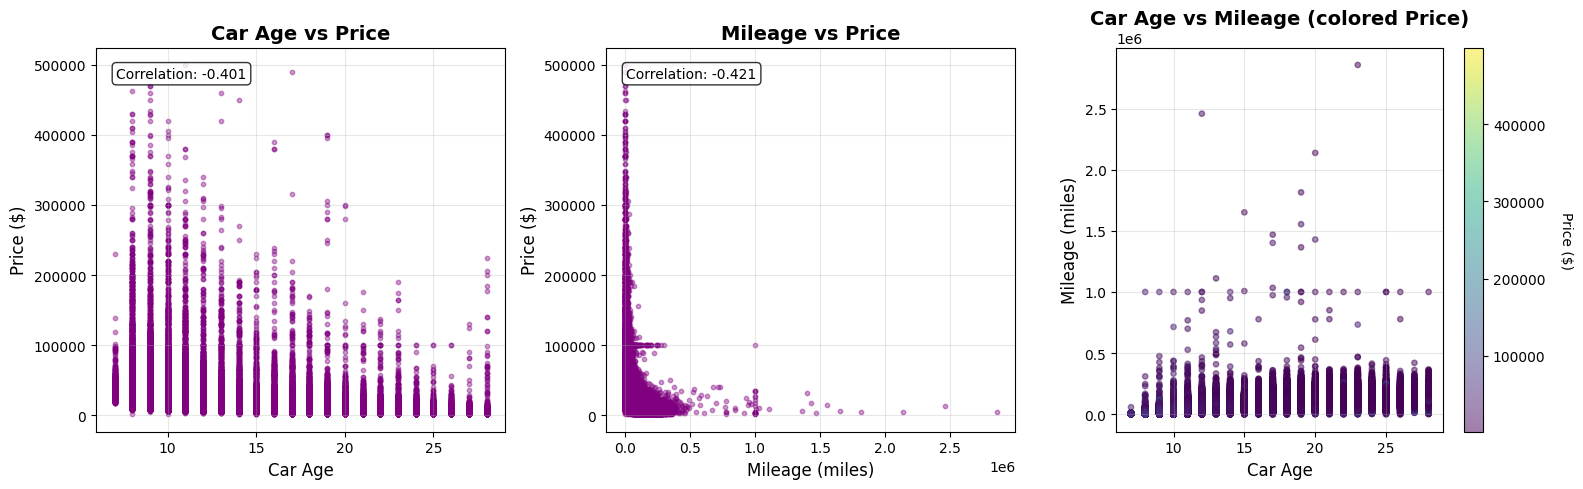

In [27]:
# Relationship Analysis: Factors Affecting Price
print("=== FACTOR ANALYSIS ===")

# Calculate correlations
corr_year = df_clean[['Car_Age', 'Price']].corr().iloc[0, 1]
corr_mileage = df_clean[['Mileage', 'Price']].corr().iloc[0, 1]

print(f"Newer cars (higher year) tend to have HIGHER prices")
print(f"Higher mileage correlates with LOWER prices")
print(f"Car Age has {abs(corr_year):.1%} correlation with price")
print(f"Mileage has {abs(corr_mileage):.1%} correlation with price")

# Car Age vs Price
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.scatter(df_clean['Car_Age'], df_clean['Price'], alpha=0.4, color='purple', s=10)
plt.title('Car Age vs Price', fontsize=14, fontweight='bold')
plt.xlabel('Car Age', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Correlation: {corr_year:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Mileage vs Price
plt.subplot(1, 3, 2)
plt.scatter(df_clean['Mileage'], df_clean['Price'], alpha=0.4, color='purple', s=10)
plt.title('Mileage vs Price', fontsize=14, fontweight='bold')
plt.xlabel('Mileage (miles)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Correlation: {corr_mileage:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Car Age vs Mileage (colored by Price)
plt.subplot(1, 3, 3)
scatter = plt.scatter(df_clean['Car_Age'], df_clean['Mileage'], 
                     c=df_clean['Price'], alpha=0.5, s=15, cmap='viridis')
plt.title('Car Age vs Mileage (colored Price)', fontsize=14, fontweight='bold')
plt.xlabel('Car Age', fontsize=12)
plt.ylabel('Mileage (miles)', fontsize=12)
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Price ($)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

## 4. Model Training - Random Forest

**Configuration (aligned with production model.py):**
- **Features:** Car_Age, Mileage, Make_Encoded, State_Encoded
- **Algorithm:** Random Forest (ensemble of 50 decision trees)
- **Max Depth:** 10 (prevents overfitting)
- **Split:** 80% training, 20% testing
- **Random State:** 42 (reproducibility)

**Why Random Forest?**
- Handles non-linear relationships
- Robust to outliers
- Provides feature importance
- Good balance of accuracy and interpretability

In [28]:
print("="*80)
print("TRAINING RANDOM FOREST MODEL")
print("="*80)

# Use same features as production (model.py)
features = ['Car_Age', 'Mileage', 'Make_Encoded', 'State_Encoded']
X = df_clean[features]
y = df_clean['Price']

print(f"\nFeatures: {', '.join(features)}")

# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]:,} | Testing samples: {X_test.shape[0]:,}")

# Train Random Forest (aligned with model.py: n_estimators=50, max_depth=10)
print("\nTraining Random Forest...")
model = RandomForestRegressor(
    n_estimators=50,    # Same as model.py
    max_depth=10,       # Same as model.py
    random_state=42,
    n_jobs=4
)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\n📊 PERFORMANCE METRICS")
print(f"   R² Train:  {r2_train:.4f}")
print(f"   R² Test:   {r2_test:.4f}")
print(f"   MAE:       ${mae_test:,.2f}")
print(f"   RMSE:      ${rmse_test:,.2f}")
print(f"   Gap:       {r2_train - r2_test:.4f}")
print("="*80)

TRAINING RANDOM FOREST MODEL

Features: Car_Age, Mileage, Make_Encoded, State_Encoded
Training samples: 681,673 | Testing samples: 170,419

Training Random Forest...
Training samples: 681,673 | Testing samples: 170,419

Training Random Forest...

📊 PERFORMANCE METRICS
   R² Train:  0.5363
   R² Test:   0.5232
   MAE:       $6,190.95
   RMSE:      $9,345.28
   Gap:       0.0131

📊 PERFORMANCE METRICS
   R² Train:  0.5363
   R² Test:   0.5232
   MAE:       $6,190.95
   RMSE:      $9,345.28
   Gap:       0.0131


## 5. Feature Importance Analysis

**Understanding Model Decisions:**

Feature importance shows which variables drive predictions:

- **Car_Age & Mileage:** Primary depreciation factors (physical wear)
- **Make_Encoded:** Brand value/reputation (Ferrari vs Ford)
- **State_Encoded:** Regional market differences (CA vs TX)

**Why it matters:** Explains *how* the model makes predictions, increasing trust and interpretability.

=== FEATURE IMPORTANCE ===

      Feature  Importance  Importance_Percent
 Make_Encoded    0.495171           49.517111
      Mileage    0.397305           39.730467
      Car_Age    0.099694            9.969411
State_Encoded    0.007830            0.783011


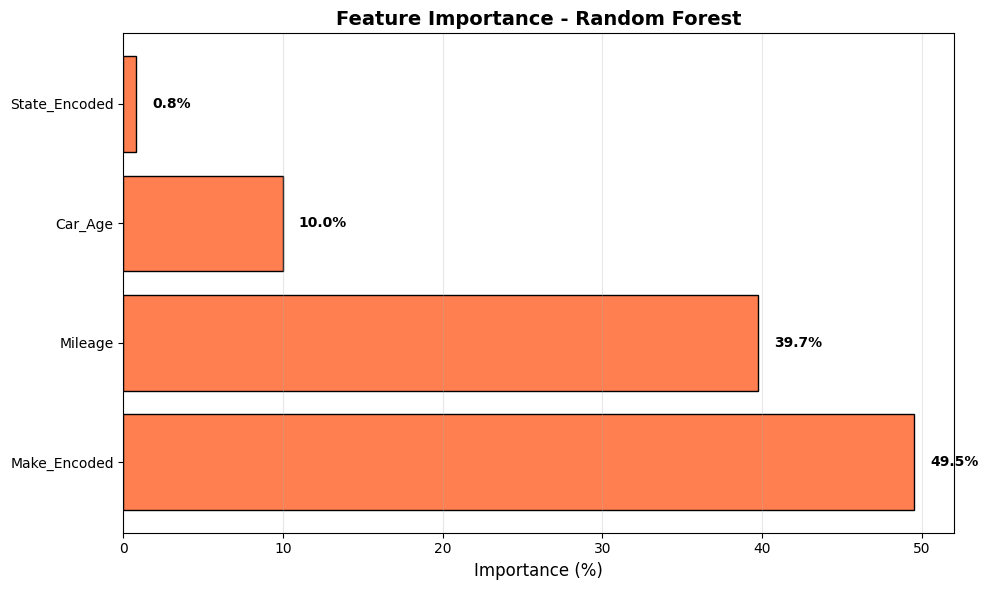

In [29]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_,
    'Importance_Percent': model.feature_importances_ * 100
}).sort_values('Importance', ascending=False)

print("=== FEATURE IMPORTANCE ===\n")
print(importance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance_Percent'], color='coral', edgecolor='black')
plt.xlabel('Importance (%)', fontsize=12)
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

for i, (feat, imp) in enumerate(zip(importance_df['Feature'], importance_df['Importance_Percent'])):
    plt.text(imp + 1, i, f'{imp:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Model Evaluation & Visualization

**Performance Metrics:**
- **R² Score:** How well the model explains price variance (0-1, higher is better)
- **MAE:** Average prediction error in dollars (lower is better)
- **RMSE:** Penalizes large errors more heavily (lower is better)

**Visualizations:**
1. **Actual vs Predicted:** Shows prediction accuracy
2. **Residual Plot:** Reveals systematic errors (should be random)

**Overfitting Check:** Compare training vs testing performance (gap should be < 0.05)

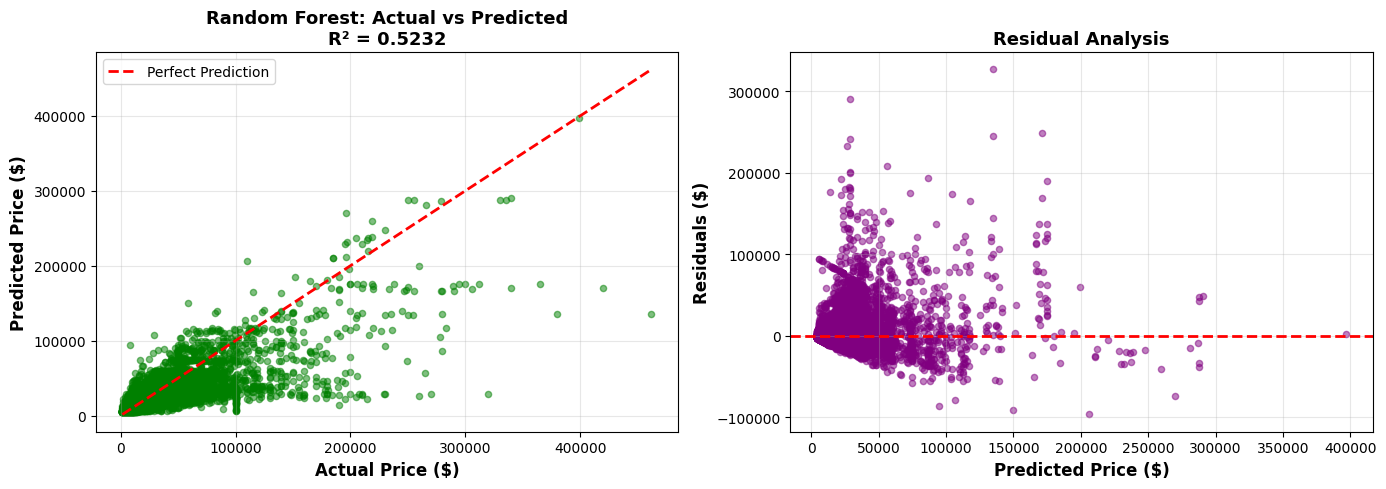


✅ GOOD FIT: Gap = 0.0131
Model explains 52.3% of price variance on test data


In [30]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Price ($)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Random Forest: Actual vs Predicted\nR² = {r2_test:.4f}', 
                 fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Residual Analysis
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5, s=20, color='purple')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Analysis', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overfitting check
r2_diff = r2_train - r2_test
if r2_diff < 0.05:
    status = "✅ GOOD FIT"
elif r2_diff < 0.10:
    status = "⚠️ SLIGHT OVERFITTING"
else:
    status = "❌ OVERFITTING"

print(f"\n{status}: Gap = {r2_diff:.4f}")
print(f"Model explains {r2_test*100:.1f}% of price variance on test data")

## 7. Production Models - Complete Comparison

**4 Models Deployed in Flask App (app.py):**

1. **Ridge Regression** - Linear baseline, fastest training
2. **Decision Tree** - Single tree, simple and interpretable
3. **HistGradientBoosting** ⭐ **RECOMMENDED** - Modern, efficient, early stopping
4. **Random Forest** - Ensemble method, robust but slower

**Why HistGradientBoosting wins:**
- Faster training than Random Forest
- Better memory efficiency
- Native missing value support
- Early stopping prevents overfitting
- Similar or better accuracy

**Below:** Train all 4 models and compare performance metrics + visualizations

TRAINING ALL PRODUCTION MODELS

[1/4] Training Ridge Regression...
[2/4] Training Decision Tree...
[3/4] Training HistGradientBoosting...
[3/4] Training HistGradientBoosting...
[4/4] Using trained Random Forest...

✅ All models trained successfully!

📊 MODEL COMPARISON
Model                        R² Test        MAE Test
--------------------------------------------------------------------------------
Ridge Regression              0.2026 $      7,722.32
Decision Tree                 0.5512 $      5,815.96
[4/4] Using trained Random Forest...

✅ All models trained successfully!

📊 MODEL COMPARISON
Model                        R² Test        MAE Test
--------------------------------------------------------------------------------
Ridge Regression              0.2026 $      7,722.32
Decision Tree                 0.5512 $      5,815.96
HistGradientBoosting          0.6133 $      5,717.60
HistGradientBoosting          0.6133 $      5,717.60
Random Forest                 0.5232 $      6,190.9

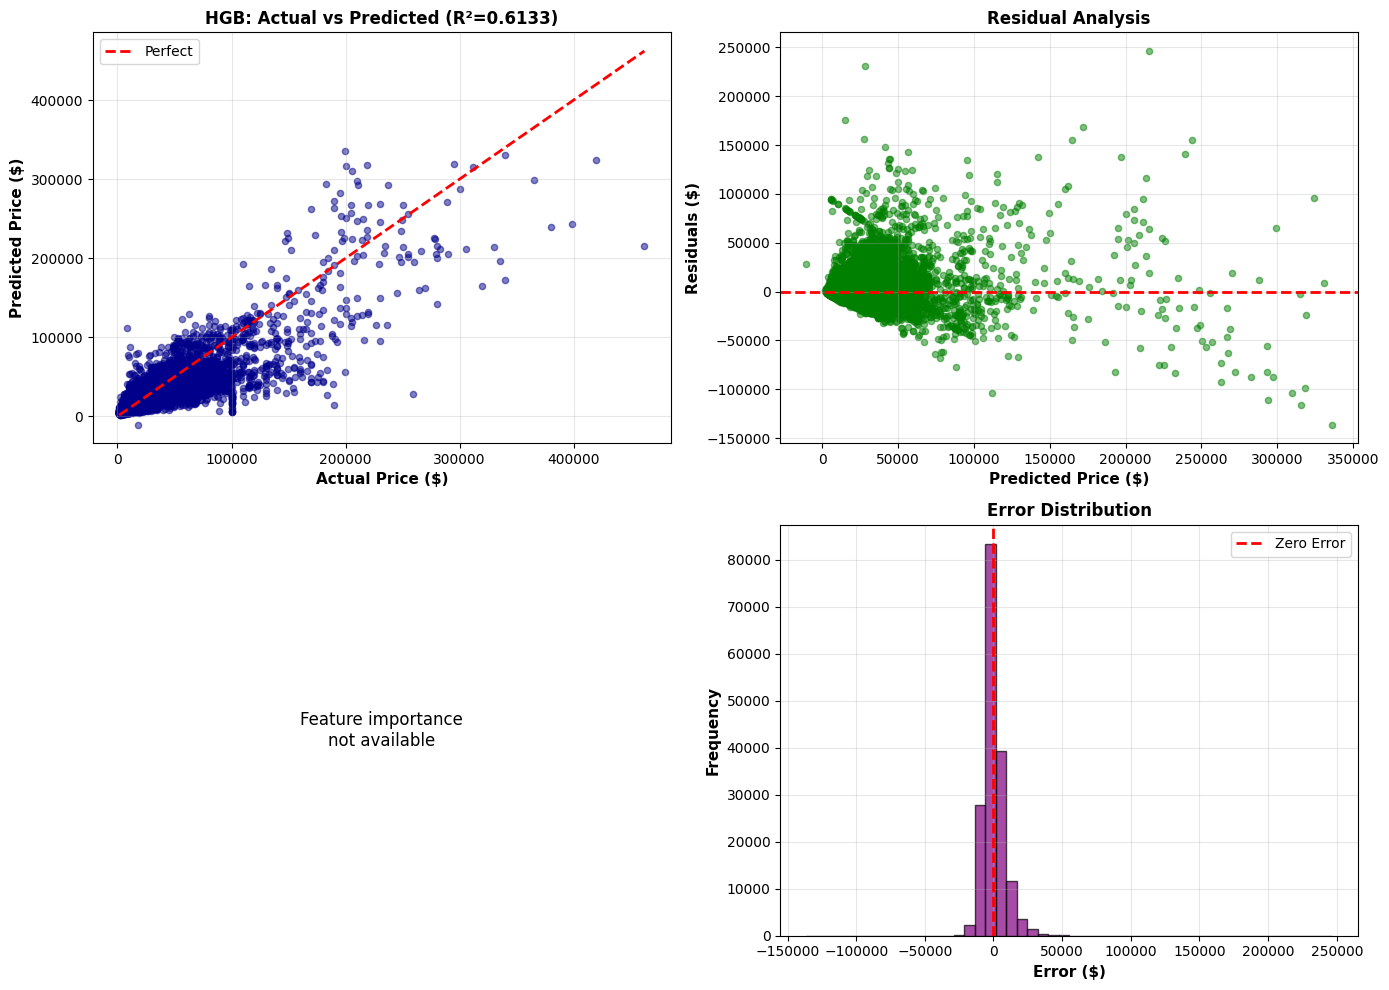


💡 HistGradientBoosting is used in production (app.py) because:
   • Faster training than Random Forest
   • Better memory efficiency
   • Early stopping prevents overfitting
   • Native missing value support

ALL MODELS COMPARISON VISUALIZATION


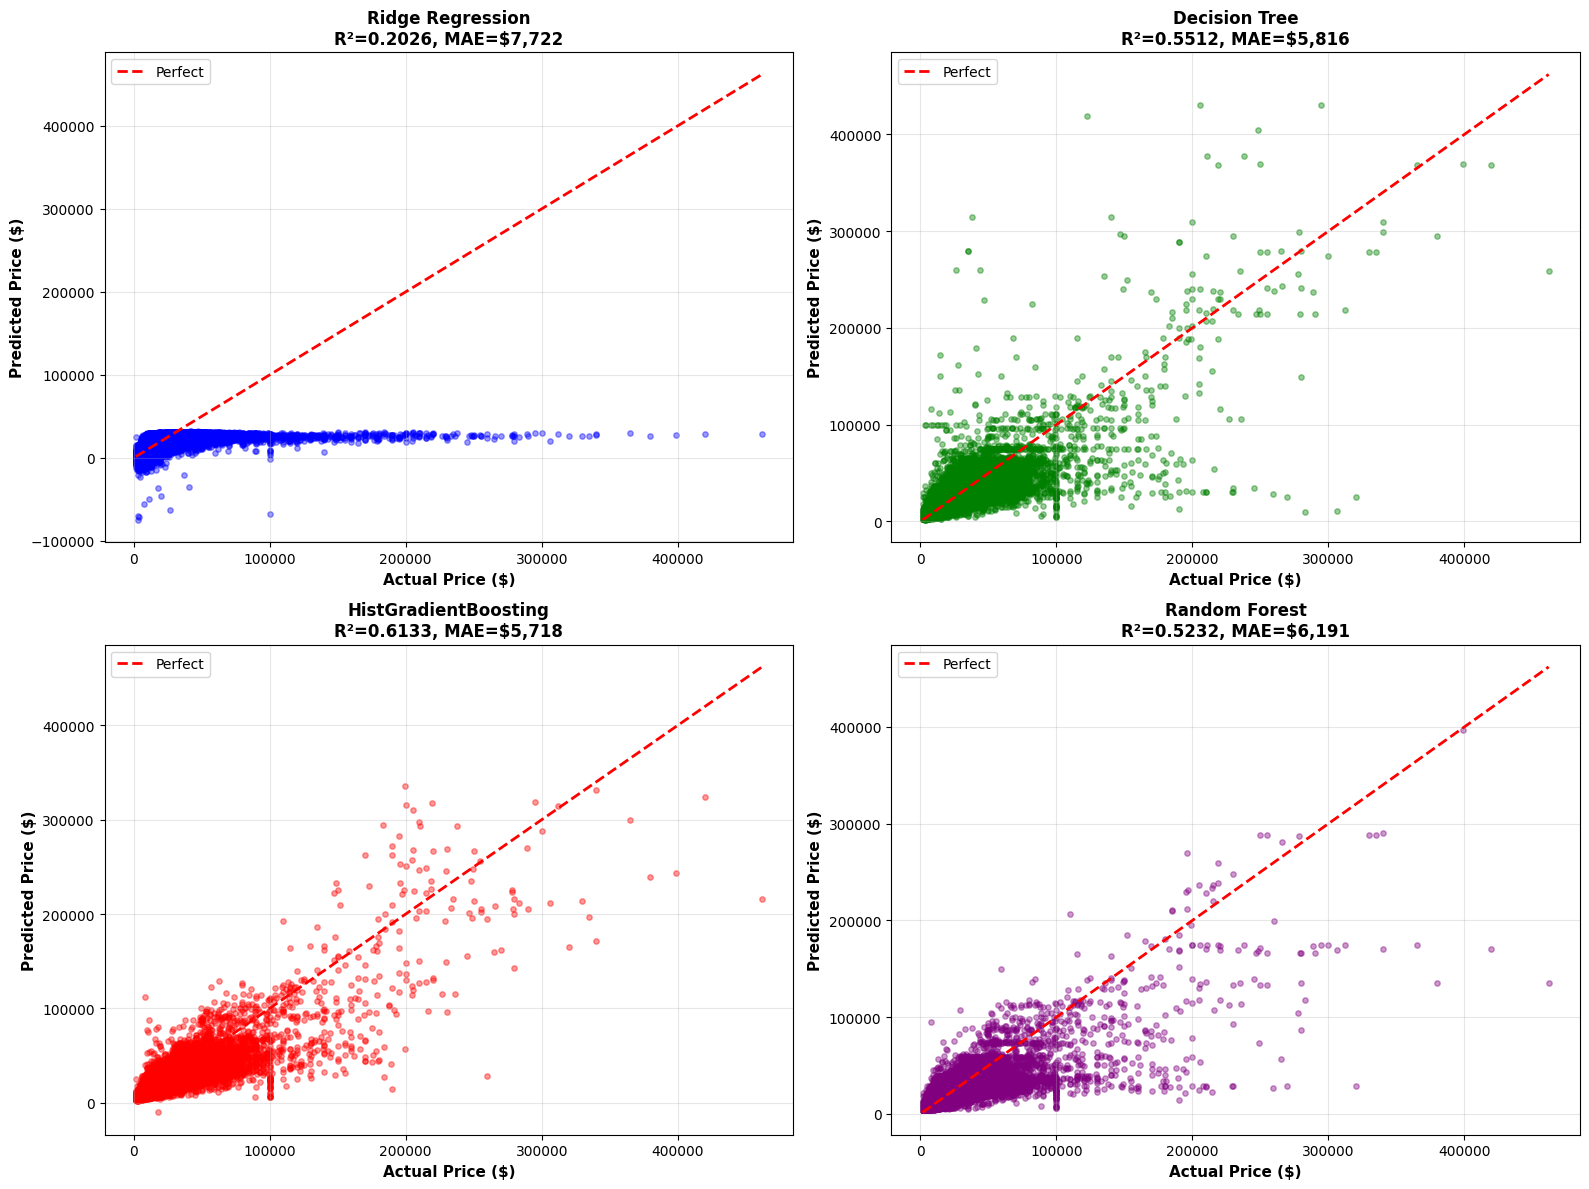


RESIDUAL ANALYSIS FOR ALL MODELS


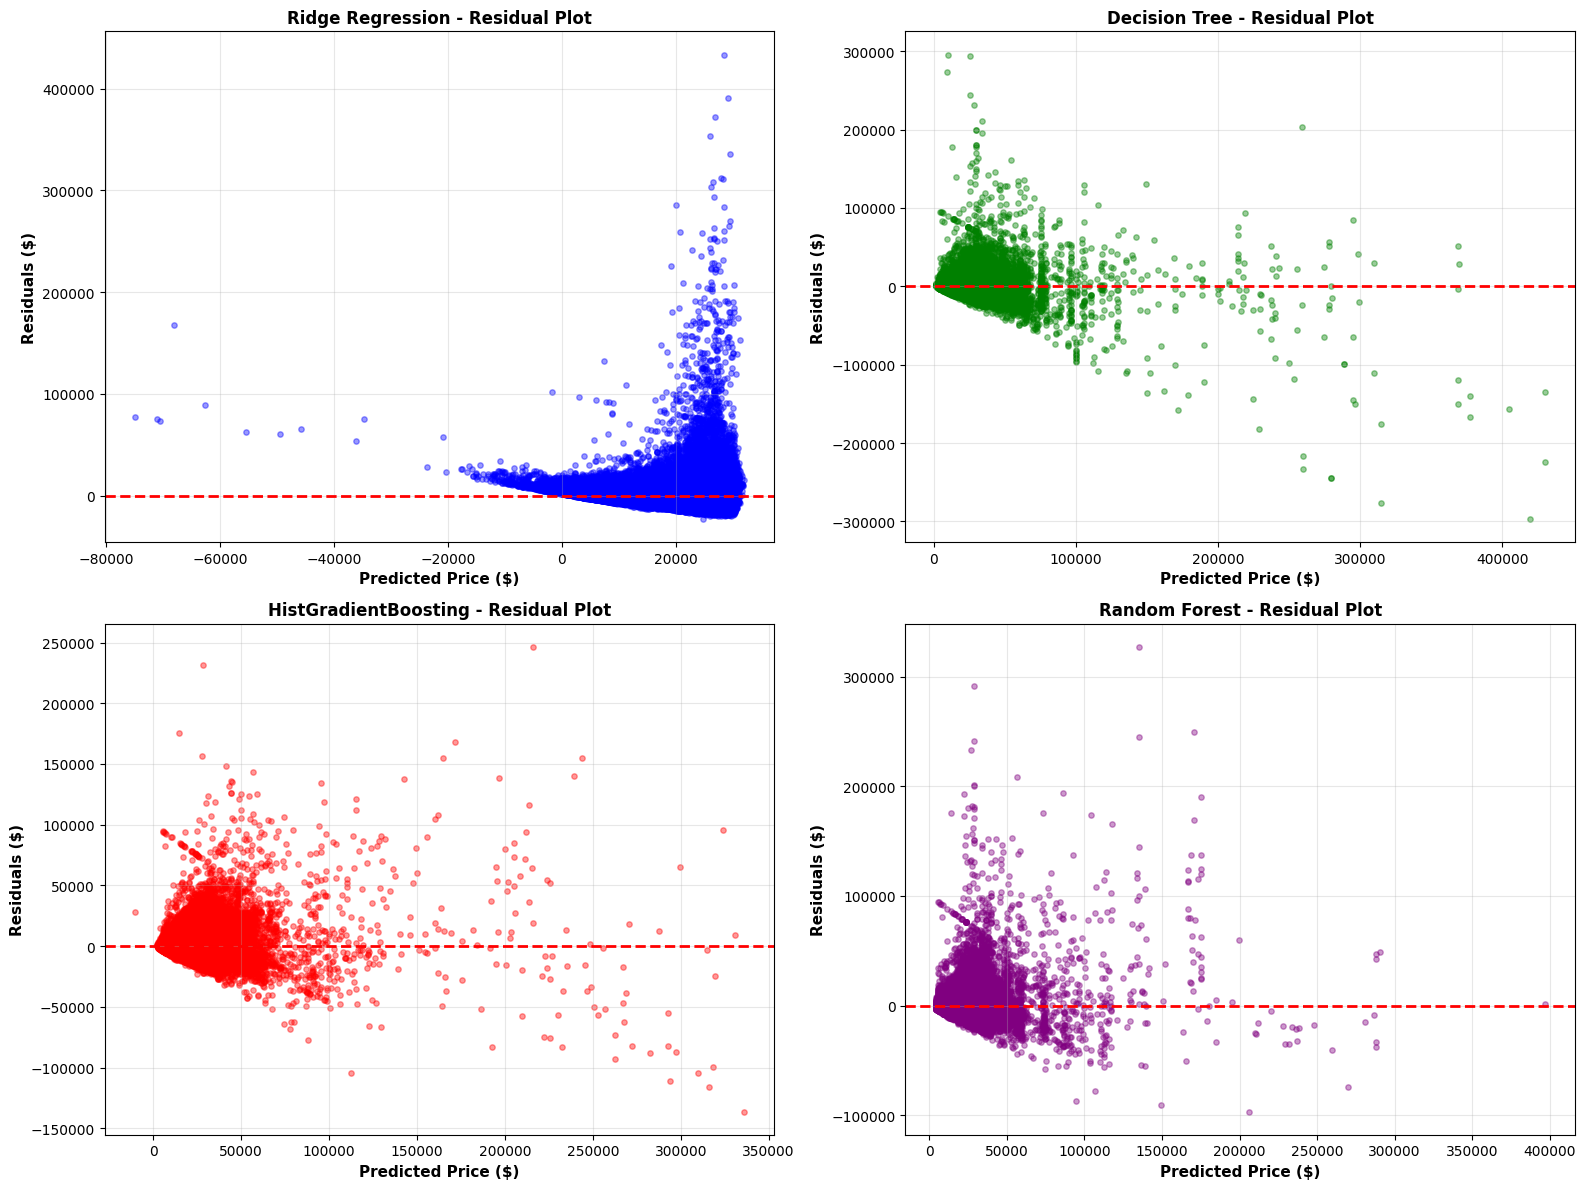

In [37]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

print("="*80)
print("TRAINING ALL PRODUCTION MODELS")
print("="*80)

# Train all 4 models (same as model.py)
models = {}

# 1. Ridge Regression
print("\n[1/4] Training Ridge Regression...")
models['ridge'] = Ridge(alpha=1.0)
models['ridge'].fit(X_train, y_train)

# 2. Decision Tree
print("[2/4] Training Decision Tree...")
models['dt'] = DecisionTreeRegressor(max_depth=15, random_state=42)
models['dt'].fit(X_train, y_train)

# 3. HistGradientBoosting (Recommended)
print("[3/4] Training HistGradientBoosting...")
models['hgb'] = HistGradientBoostingRegressor(
    max_iter=150,
    max_depth=None,
    learning_rate=0.1,
    random_state=42,
    early_stopping=True
)
models['hgb'].fit(X_train, y_train)

# 4. Random Forest (already trained above as 'model')
print("[4/4] Using trained Random Forest...")
models['rf'] = model

print("\n✅ All models trained successfully!")

# Compare performance
print("\n" + "="*80)
print("📊 MODEL COMPARISON")
print("="*80)
print(f"{'Model':<25} {'R² Test':>10} {'MAE Test':>15}")
print("-"*80)

model_names = {
    'ridge': 'Ridge Regression',
    'dt': 'Decision Tree',
    'hgb': 'HistGradientBoosting',
    'rf': 'Random Forest'
}

results = {}
for key, mdl in models.items():
    y_pred = mdl.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[key] = {'r2': r2, 'mae': mae}
    print(f"{model_names[key]:<25} {r2:>10.4f} ${mae:>14,.2f}")

print("="*80)

# Best model
best_model = max(results.items(), key=lambda x: x[1]['r2'])
print(f"\n✅ Best R²: {model_names[best_model[0]]} ({best_model[1]['r2']:.4f})")

# Visualize HGB (production recommended)
print("\n" + "="*80)
print("HISTGRADIENTBOOSTING VISUALIZATION (Production Model)")
print("="*80)

hgb_pred = models['hgb'].predict(X_test)
hgb_r2 = results['hgb']['r2']
hgb_mae = results['hgb']['mae']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test, hgb_pred, alpha=0.5, s=20, color='darkblue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Price ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Price ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'HGB: Actual vs Predicted (R²={hgb_r2:.4f})', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals_hgb = y_test - hgb_pred
axes[0, 1].scatter(hgb_pred, residuals_hgb, alpha=0.5, s=20, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Price ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Residual Analysis', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Feature Importance (if available)
if hasattr(models['hgb'], 'feature_importances_'):
    importances = models['hgb'].feature_importances_
    feat_names = ['Car_Age', 'Mileage', 'Make_Encoded', 'State_Encoded']
    axes[1, 0].barh(feat_names, importances, color='teal', edgecolor='black')
    axes[1, 0].set_xlabel('Importance', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Feature Importance', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Feature importance\nnot available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].axis('off')

# Plot 4: Error Distribution
axes[1, 1].hist(residuals_hgb, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].set_xlabel('Error ($)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 HistGradientBoosting is used in production (app.py) because:")
print(f"   • Faster training than Random Forest")
print(f"   • Better memory efficiency")
print(f"   • Early stopping prevents overfitting")
print(f"   • Native missing value support")

print("="*80)

# Visualize ALL models comparison
print("\n" + "="*80)
print("ALL MODELS COMPARISON VISUALIZATION")
print("="*80)

fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))

model_colors = {'ridge': 'blue', 'dt': 'green', 'hgb': 'red', 'rf': 'purple'}

for idx, (key, mdl) in enumerate(models.items()):
    row = idx // 2
    col = idx % 2
    
    y_pred = mdl.predict(X_test)
    r2 = results[key]['r2']
    mae = results[key]['mae']
    
    axes2[row, col].scatter(y_test, y_pred, alpha=0.4, s=15, color=model_colors[key])
    axes2[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                         'r--', lw=2, label='Perfect')
    axes2[row, col].set_xlabel('Actual Price ($)', fontsize=11, fontweight='bold')
    axes2[row, col].set_ylabel('Predicted Price ($)', fontsize=11, fontweight='bold')
    axes2[row, col].set_title(f'{model_names[key]}\nR²={r2:.4f}, MAE=${mae:,.0f}', 
                              fontsize=12, fontweight='bold')
    axes2[row, col].legend()
    axes2[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual plots for all models
print("\n" + "="*80)
print("RESIDUAL ANALYSIS FOR ALL MODELS")
print("="*80)

fig3, axes3 = plt.subplots(2, 2, figsize=(16, 12))

for idx, (key, mdl) in enumerate(models.items()):
    row = idx // 2
    col = idx % 2
    
    y_pred = mdl.predict(X_test)
    residuals = y_test - y_pred
    
    axes3[row, col].scatter(y_pred, residuals, alpha=0.4, s=15, color=model_colors[key])
    axes3[row, col].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes3[row, col].set_xlabel('Predicted Price ($)', fontsize=11, fontweight='bold')
    axes3[row, col].set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
    axes3[row, col].set_title(f'{model_names[key]} - Residual Plot', 
                              fontsize=12, fontweight='bold')
    axes3[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*80)